/tmp/ipython-input-3119480814.py:51: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


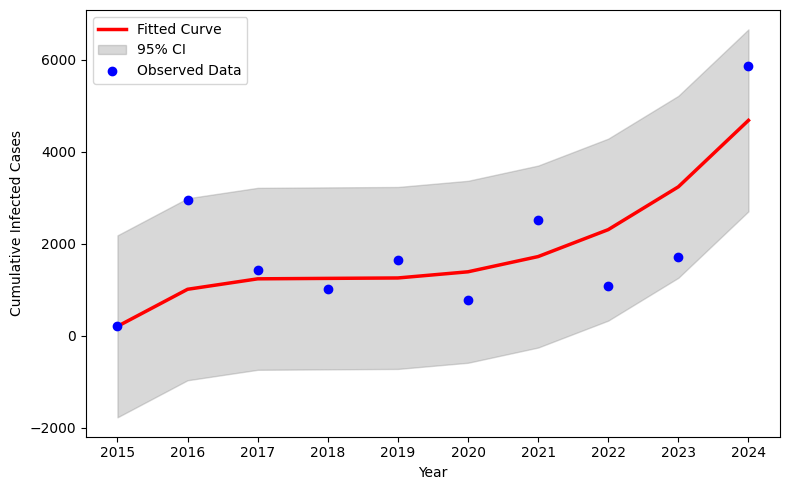

Estimated parameters:
0.50148, 0.56147, 0.24393, 0.51942, 0.76972, 0.24721, 0.17025, 0.12127


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 207, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/maharashachiken.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.48939, 0.56302, 0.31158, 0.51199, 0.88468, 0.12015, 0.17718, 0.13396]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 207, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))


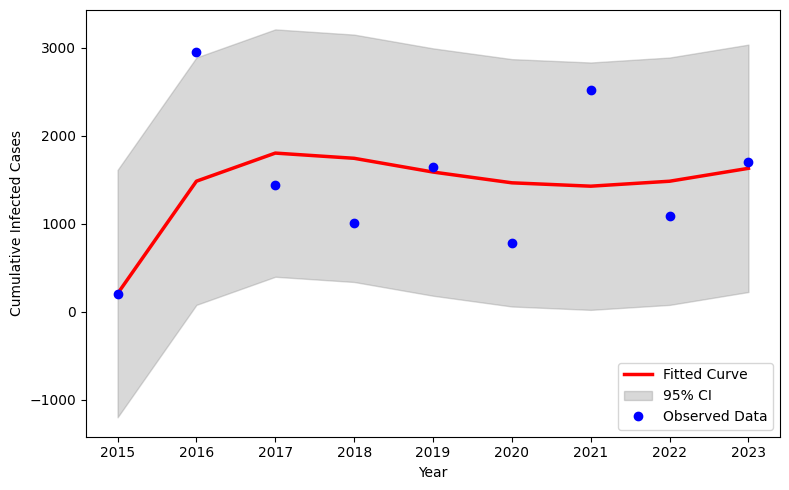

Estimated parameters:
0.35374, 0.69011, 0.27331, 0.62988, 0.80615, 0.13443, 0.14778, 0.05783


In [ ]:
# it is good only but i will try for more in next
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 207, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/maharashachiken1.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.36685, 0.65990, 0.31478, 0.60403, 0.82761, 0.15124, 0.16858, 0.08048]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 207, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))


/tmp/ipython-input-4264984031.py:51: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


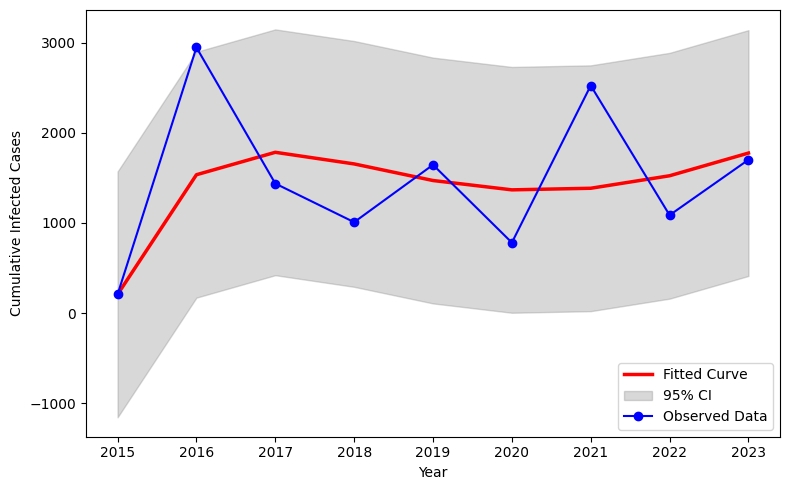

Estimated parameters:
0.38792, 0.79255, 0.28560, 0.65632, 0.88299, 0.19981, 0.14140, 0.04514


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    r = 0.6
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt = r * Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt = (1 - r) * Lambda_h - ((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v

    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 5000, 469, 207, 3000, 37510300, 49638138, 7802, 1300]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 4]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/maharashachiken1.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.39117, 0.78988, 0.28498, 0.65710, 0.88703, 0.19675, 0.14060, 0.04133]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 1000000, 5000, 469, 207, 3000, 37510300, 49638138, 7802, 1300]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 4][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo-', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))


/tmp/ipython-input-3538716742.py:52: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


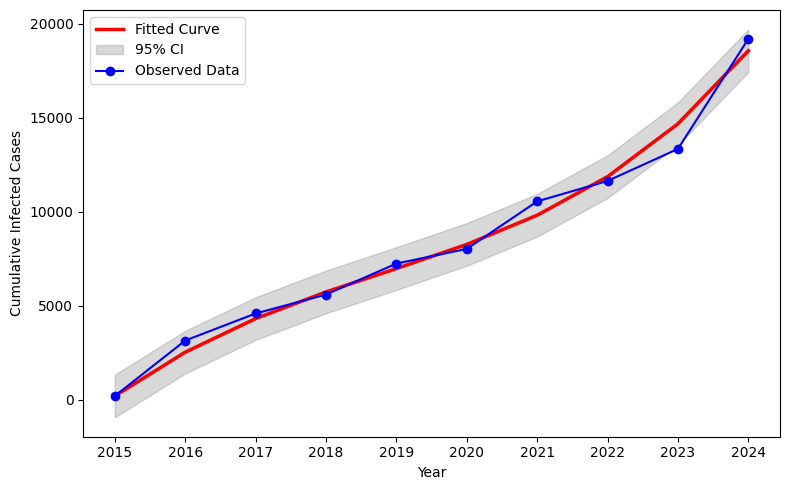

Estimated parameters:
0.19937, 1.33021, 0.02432, 0.05261, 0.71812, 0.07608, 0.46146, 0.14318


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v, C = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt =  Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt =  -((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v
    dCdt = (1 - kappa) * epsilon * E_h


    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt, dCdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 2500, 469, 207, 3000, 37510300, 49638138, 7802, 1300, 207]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 10]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/maharashachikencumulative.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
initial_guess = [0.21011, 1.32622, 0.02210, 0.05347, 0.71603, 0.08011, 0.45699, 0.13948]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 500000, 2500, 469, 207, 3000, 37510300, 49638138, 7802, 1300, 207]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 10][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo-', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()
plt.show()

# Save the figure before showing it
plt.savefig('Maharastra_Cumulative_chiken.png', dpi=300, bbox_inches='tight')


print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))

/tmp/ipython-input-518309368.py:52: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))


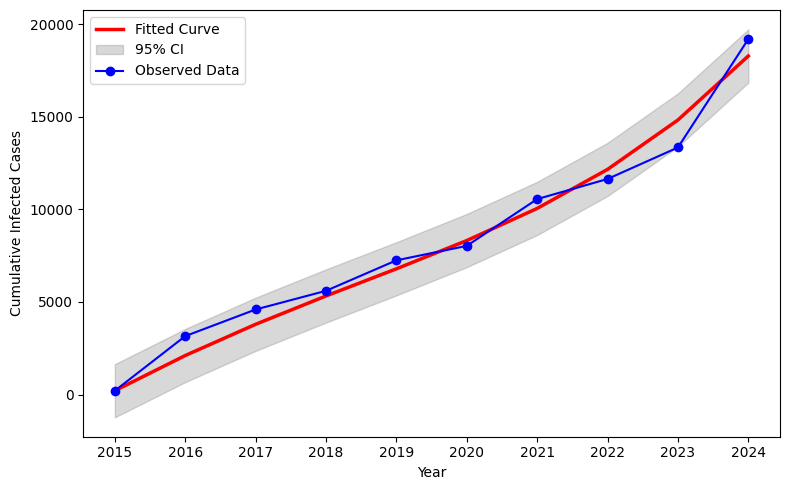

Estimated parameters:
0.12416, 0.92278, 0.07624, 0.27295, 0.85791, 0.12067, 0.44533, 0.05442


In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -------------------------
# SEIR Model Definition
# -------------------------
def seir_model(y, t, kappa, epsilon, gamma, alpha, eta, beta, tau, delta):
    S_u, S_a, E_h, I_a, I_s, R, M, S_v, E_v, I_v, C = y
    N_h = S_u + S_a + E_h + I_a + I_s + R
    N_v = S_v + E_v + I_v

    Lambda_h = 908800
    Lambda_v = 7008000000
    mu = 0.0142
    mu_v = 0.5

    mu1 = 0.001
    mu2 = 0.073
    b = 0.6
    c = 0.3
    d = 0.45
    e = 0.8

    sigma = 0.34074
    phi = 0.81425
    rho = 0.52869

    dS_udt =  Lambda_h - (b * beta * I_v * S_u) / N_h - sigma * S_u * M - mu * S_u + phi * S_a
    dS_adt =  -((1 - eta) * (c * beta * I_v * S_a)) / N_h + sigma * S_u * M - (phi + mu) * S_a
    dE_hdt = ((1 - eta) * (c * beta * I_v * S_a)) / N_h + (b * beta * I_v * S_u) / N_h - (kappa * epsilon + mu) * E_h
    dI_adt = kappa * epsilon * E_h - (gamma + mu + mu1) * I_a
    dI_sdt = (1 - kappa) * epsilon * E_h - (alpha + mu + mu2) * I_s
    dRdt = gamma * I_a + alpha * I_s - mu * R
    dMdt = tau * I_s - delta * M
    dS_vdt = Lambda_v - (d * beta * S_v * I_a) / N_h - (e * beta * S_v * I_s) / N_h - mu_v * S_u
    dE_vdt = (d * beta * S_v * I_a) / N_h + (e * beta * S_v * I_s) / N_h - (rho + mu_v) * E_v
    dI_vdt = rho * E_v - mu_v * I_v
    dCdt = (1 - kappa) * epsilon * E_h


    return [dS_udt, dS_adt, dE_hdt, dI_adt, dI_sdt, dRdt, dMdt, dS_vdt, dE_vdt, dI_vdt, dCdt]

# -------------------------
# Log-likelihood
# -------------------------
def log_likelihood(params, t, observed_cumulative):
    kappa, epsilon, gamma, alpha, eta, beta, tau, delta = params
    y0 = [60439692, 1000000, 2500, 469, 207, 3000, 37510300, 49638138, 7802, 1300, 207]
    solution = odeint(seir_model, y0, t, args=(kappa, epsilon, gamma, alpha, eta, beta, tau, delta))
    predicted_cumulative = solution[:, 10]  # I_s index
    return -0.5 * np.sum((observed_cumulative - predicted_cumulative) ** 2)

# -------------------------
# Load Data
# -------------------------
file_name = '/content/maharashachikencumulative.xlsx'
df = pd.read_excel(file_name)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
years_since_min = df['Year'].dt.year - df['Year'].dt.year.min()
infected = df['Cases'].values

# -------------------------
# Optimization
# -------------------------
# initial_guess = [0.21011, 1.32622, 0.02210, 0.05347, 0.71603, 0.08011, 0.45699, 0.13948]
initial_guess = [0.12339, 0.92243, 0.07626, 0.27265, 0.85802, 0.12036, 0.44575, 0.05440]
neg_log_likelihood = lambda params: -log_likelihood(params, years_since_min, infected)
bounds = [(None, None)] * len(initial_guess)
result = minimize(neg_log_likelihood, initial_guess, method='L-BFGS-B', bounds=bounds)
params = result.x

# -------------------------
# Solve ODE with optimized parameters
# -------------------------
y0 = [60439692, 500000, 2500, 469, 207, 3000, 37510300, 49638138, 7802, 1300, 207]
fitted_solution = odeint(seir_model, y0, years_since_min, args=tuple(params))
predicted_A = fitted_solution[:, 10][:len(infected)]

# -------------------------
# Simple residual-based 95% CI
# -------------------------
residuals = infected - predicted_A
std_error = np.std(residuals)
ci_upper = predicted_A + 1.96 * std_error
ci_lower = predicted_A - 1.96 * std_error

# -------------------------
# Plot with CI
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(df['Year'].dt.year, predicted_A, 'r-', label='Fitted Curve', linewidth=2.5)
plt.fill_between(df['Year'].dt.year, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')
plt.plot(df['Year'].dt.year, infected, 'bo-', label='Observed Data', markersize=6)

plt.xlabel('Year')
plt.ylabel('Cumulative Infected Cases')
plt.xticks(sorted(df['Year'].dt.year.unique()))
plt.legend()
plt.tight_layout()

# ✅ Save before showing
plt.savefig('maharashatra_Cumulative_chiken.png', dpi=300, bbox_inches='tight')
plt.show()

print("Estimated parameters:")
print(", ".join([f"{p:.5f}" for p in params]))